<a href="https://colab.research.google.com/github/CutVonDrake/TestingGit/blob/main/Resnetart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

# Percorso al file compresso
zip_path = r"/content/Dataset1/testing_dataset.zip"  # Modifica con il percorso al tuo file .zip
extract_dir = r"/content/Dataset1/testing_dataset"  # Cartella temporanea per estrarre i file



# Estrai il contenuto del file .zip
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)





Classi (pittori): ['testing_dataset']


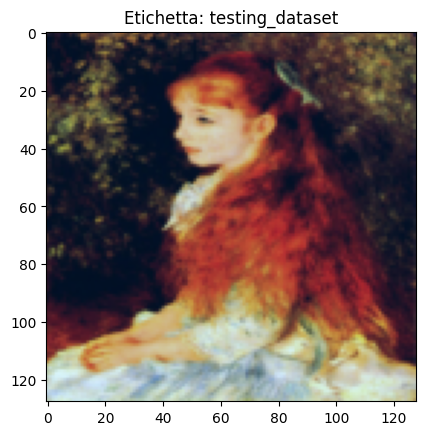

In [ ]:

# Trasformazioni per le immagini
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Ridimensiona le immagini per uniformità
    transforms.ToTensor(),  # Converte le immagini in tensori
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizzazione
])

# Carica tutte le immagini dal dataset estratto
dataset = datasets.ImageFolder(root=extract_dir, transform=transform)

# DataLoader per caricare i dati in batch
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Verifica le classi (sottocartelle come etichette)
print("Classi (pittori):", dataset.classes)

# Carica un batch per visualizzare immagini e relative etichette
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Denormalizzazione per visualizzare un'immagine
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Denormalizza la prima immagine del batch
denormalized_image = images[0] * std[:, None, None] + mean[:, None, None]
np_image = denormalized_image.permute(1, 2, 0).numpy()

# Visualizza l'immagine e la classe associata
plt.imshow(np_image)
plt.title(f"Etichetta: {dataset.classes[labels[0]]}")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image

# Definizione dei blocchi della rete (come nel tuo codice originale)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = torch.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# Funzioni per il dataset
def get_data_loaders(batch_size=100):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = dataset
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = dataset
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader




In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()





# Funzione per creare ResNet18
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


# Funzione di allenamento
def train_model(net, trainloader, num_epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print loss statistics
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

    print("Finished Training")


# Funzione di valutazione
def evaluate_model(net, testloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy of the network on test images: {100 * correct / total:.2f}%")


# Funzione per la classificazione di immagini personalizzate
def classify_image(net, image_path, classes):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = net(image)
        _, predicted = torch.max(output.data, 1)
        print(f"Predicted class: {classes[predicted[0]]}")


# Blocco principale
if __name__ == '__main__':
    # Carica i dati
    trainloader, testloader = get_data_loaders()

    # Inizializza la rete
    net = ResNet18()

    # Allena il modello
    train_model(net, trainloader)

    # Valuta il modello
    evaluate_model(net, testloader)


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 1.06 MiB is free. Process 2415 has 14.74 GiB memory in use. Of the allocated memory 14.62 GiB is allocated by PyTorch, and 10.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import random
from torch.utils.data import Subset

# Funzione per caricare metà del dataset
def get_half_dataset(dataset):
    # Calcola il numero totale di immagini nel dataset
    total_images = len(dataset)

    # Calcola il numero di immagini da selezionare (metà del dataset)
    half_size = total_images // 2

    # Seleziona casualmente metà delle immagini
    indices = random.sample(range(total_images), half_size)

    # Crea un subset del dataset
    subset = Subset(dataset, indices)

    return subset

# Funzione per creare ResNet18
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


# Funzione di allenamento
def train_model(net, trainloader, num_epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print loss statistics
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

    print("Finished Training")


# Funzione di valutazione
def evaluate_model(net, testloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy of the network on test images: {100 * correct / total:.2f}%")


# Funzione per la classificazione di immagini personalizzate
def classify_image(net, image_path, classes):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = net(image)
        _, predicted = torch.max(output.data, 1)
        print(f"Predicted class: {classes[predicted[0]]}")


# Blocco principale
if __name__ == '__main__':
    # Carica il dataset completo
    dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

    # Ottieni metà del dataset
    half_dataset = get_half_dataset(dataset)

    # Crea un DataLoader per la metà del dataset
    trainloader = DataLoader(half_dataset, batch_size=32, shuffle=True)

    # Carica i dati di test (per la valutazione finale, non influenzato dal subset)
    testloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Inizializza la rete
    net = ResNet18()

    # Allena il modello sulla metà del dataset
    train_model(net, trainloader)

    # Valuta il modello sul dataset di test completo
    evaluate_model(net, testloader)


NameError: name 'dataset_dir' is not defined